In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [2]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [3]:
def pieOthers(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
        
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    colorsX = plt.cm.tab20.colors
    patches, texts = plt.pie(df2['value'], shadow=True, startangle=90, colors = colorsX)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
def pieOthers2(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
    
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    fig=plt.figure(figsize=(7,5))
    gs1 = gridspec.GridSpec(1,1,
        left=0.1,right=0.7,
        bottom=0.1,top=0.7,
    )
    pie_ax=fig.add_subplot(gs1[0])
    
    colors = plt.cm.tab20.colors
    wedges, texts = pie_ax.pie(
        df2['value'],
        shadow=True,
        colors=colors,
        startangle=90,
    )
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
        pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    pie_ax.axis('equal')

    plt.show()

In [4]:
cols = ['model', 'manufacturer', 'brand', 'product', 'os_version', 'codename', 'kernel_version', 'is_root']
df = prepare('2-datasets/devices.parquet',cols)

In [5]:
df.head(100)

,model,manufacturer,brand,product,os_version,codename,kernel_version,is_root
0,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow,3.10.49-gf18313b-00011-g5e5ed63,0
1,AO5510,YU,YU,YUREKA,5.1.1,Lollipop,3.10.49-cyanogenmod-gbca6118,1
2,ASUS_X014D,ASUS,ASUS,WW_PHONE,5.1.1,Lollipop,3.4.0-gdf95949-dirty,0
3,NEXUS 5,LGE,GOOGLE,HAMMERHEAD,6.0.1,Marshmallow,3.4.0-gcf10b7e,0
4,LG-D331,LGE,LGE,LUV80SS_GLOBAL_COM,4.4.2,KitKat,3.4.67,0
...,...,...,...,...,...,...,...,...
95,SM-N950F,SAMSUNG,SAMSUNG,GREATLTEXX,7.1.1,Nougat,4.4.13-12007350,0
96,A0001,ONEPLUS,ONEPLUS,BACON,7.1.2,Nougat,3.4.113-lineageos,1
97,ASUS_Z00AD,ASUS,ASUS,WW_Z00A,6.0.1,Marshmallow,3.10.72-x86_64_moor-gb6d574d,0
98,HUAWEI VNS-L31,HUAWEI,HUAWEI,VNS-L31,7.0,Nougat,4.1.18-g436da75,0


In [12]:
dfModelGB = df.groupby(['model'])['model'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfManufacturerGB = df.groupby(['manufacturer'])['manufacturer'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfBrandGB = df.groupby(['brand'])['brand'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfProductGB = df.groupby(['product'])['product'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfOsVersionGB = df.groupby(['os_version'])['os_version'].count().reset_index(name='count').sort_values(['count'], ascending=False)
dfCodenameGB = df.groupby(['codename'])['codename'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

In [11]:
print(dfModelGB['model'].count())
print(dfBrandGB['brand'].count())
print(dfOsVersionGB['os_version'].count())

9560
1639
54


In [7]:
print("Devices:"+str(df.shape[0]))

Devices:87200


                model  count
7491         SM-J200G   1236
7279         SM-G532G   1158
6656         REDMI 4A    984
6660         REDMI 5A    963
411              A37F    773
1781          CPH1803    737
8772        VIVO 1606    629
752   ANDROMAX A16C3H    559
6670     REDMI NOTE 4    528
7281         SM-G532M    491
7596         SM-J700F    438
7481         SM-J111F    425
7267         SM-G530H    410
412             A37FW    407
7278         SM-G532F    392
6663         REDMI 6A    375
6668     REDMI NOTE 3    341
7299         SM-G610F    328
4207     LENOVO A1000    326
7603         SM-J701F    324


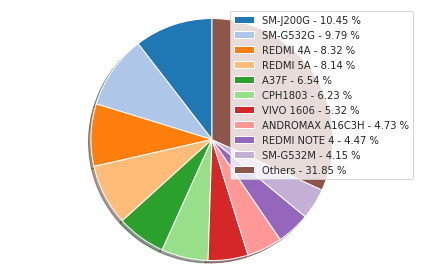

In [8]:
print(dfModelGB)
pieOthers(dfModelGB['model'],dfModelGB['count'],10)

     manufacturer  count
1119      SAMSUNG  22974
1454       XIAOMI   6633
947          OPPO   5315
528        HUAWEI   4449
746           LGE   3422
736        LENOVO   2999
858      MOTOROLA   2837
1382         VIVO   2564
136          ASUS   2124
819      MICROMAX   1997
54          ADVAN   1692
1254          TCL   1489
724          LAVA   1345
1512          ZTE   1338
494         HAIER   1085
1179         SONY    979
615          ITEL    959
85           ALPS    859
1037      QMOBILE    838
592         INTEX    624


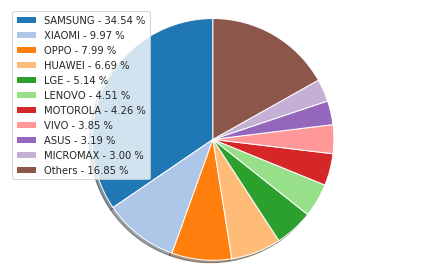

In [9]:
print(dfManufacturerGB)
pieOthers(dfManufacturerGB['manufacturer'],dfManufacturerGB['count'],10)

          brand  count
1222    SAMSUNG  22704
1576     XIAOMI   6632
1040       OPPO   5314
567      HUAWEI   3804
805         LGE   3263
796      LENOVO   2992
920    MOTOROLA   2830
1497       VIVO   2603
155        ASUS   2122
878    MICROMAX   1990
66        ADVAN   1750
1349        TCL   1699
1634        ZTE   1334
784        LAVA   1272
659        ITEL   1116
1264  SMARTFREN   1098
1280       SONY    878
1136    QMOBILE    872
1360      TECNO    831
411    EVERCOSS    761


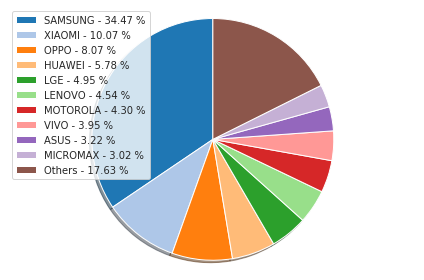

In [10]:
print(dfBrandGB)
pieOthers(dfBrandGB['brand'],dfBrandGB['count'],10)

            product  count
4334        J2LTEDD   1236
3416   GRANDPPLTEDX   1117
7264          ROLEX    980
7225           RIVA    956
9183       WW_PHONE    906
497            A37F    774
2003        CPH1803    737
11             1606    661
392          A16C3H    556
3419   GRANDPPLTEUB    491
4471       J7ELTEXX    430
7510        SANTONI    428
4291   J1ACEVELTEJV    425
498           A37FW    407
3418  GRANDPPLTESER    392
5608           MIDO    388
1757         CACTUS    355
358           A1000    338
8616        UGGLITE    328
6967       Q402PLUS    325


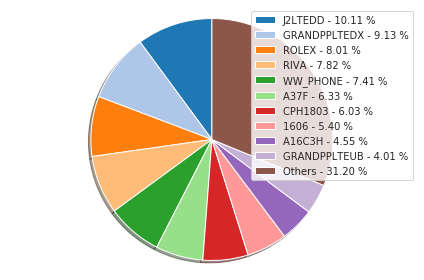

In [11]:
print(dfProductGB)
pieOthers(dfProductGB['product'],dfProductGB['count'],10)

   os_version  count
32        7.0  12291
26        6.0  11985
29      6.0.1  10808
22      5.1.1  10149
43      8.1.0   7638
21        5.1   7528
14      4.4.2   4897
36      7.1.1   3621
37      7.1.2   3198
40      8.0.0   3064
20      5.0.2   2534
16      4.4.4   2181
18        5.0   1595
6       4.2.2   1470
45          9   1433
4       4.1.2    983
19      5.0.1    726
7         4.3    390
2       4.0.4    146
31        6.1     93


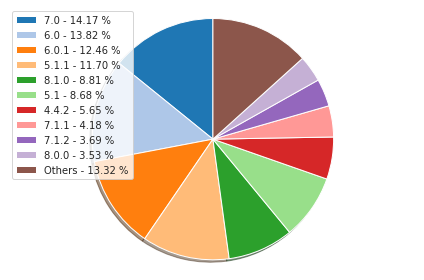

In [12]:
print(dfOsVersionGB)
pieOthers(dfOsVersionGB['os_version'],dfOsVersionGB['count'],10)

             codename  count
4         Marshmallow  22918
3            Lollipop  22536
6              Nougat  19161
7                Oreo  10802
2              KitKat   7123
1          Jelly Bean   2997
8                 Pie   1442
0  Ice Cream Sandwich    209
5             No name      9
9             Unknown      3


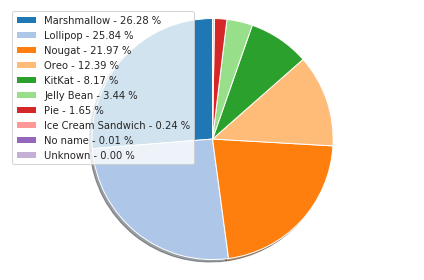

In [13]:
print(dfCodenameGB)
pieOthers(dfCodenameGB['codename'],dfCodenameGB['count'],0)